In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras

In [ ]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from tensorflow.keras.optimizers import RMSprop
# from keras.optimizers import RMSprop


In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
# from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
# from keras.layers.normalization import BatchNormalization

from tensorflow.keras.layers import (
    BatchNormalization, Input,Dense,Flatten,Dropout,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
)


from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
# from keras.utils import to_categorical

In [ ]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data

def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

In [ ]:
train_data = extract_data('/content/drive/MyDrive/7th- Semester/FashionMNIST/train-images-idx3-ubyte.gz', 60000)
test_data = extract_data('/content/drive/MyDrive/7th- Semester/FashionMNIST/t10k-images-idx3-ubyte.gz', 10000)


train_labels = extract_labels('/content/drive/MyDrive/7th- Semester/FashionMNIST/train-labels-idx1-ubyte.gz',60000)
test_labels = extract_labels('/content/drive/MyDrive/7th- Semester/FashionMNIST/t10k-labels-idx1-ubyte.gz',10000)

In [ ]:
print("Training set (images) shape: {shape}".format(shape=train_data.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=test_data.shape))

Training set (images) shape: (60000, 28, 28)
Test set (images) shape: (10000, 28, 28)


In [ ]:
# Create dictionary of target classes
label_dict = {
 0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
}

Text(0.5, 1.0, '(Label: E)')

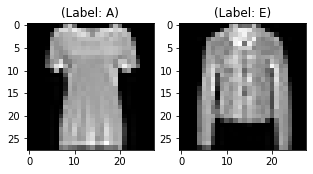

In [ ]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_data[10], (28,28))
curr_lbl = train_labels[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test_data[10], (28,28))
curr_lbl = test_labels[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

In [ ]:
train_data = train_data.reshape(-1, 28,28, 1)
test_data = test_data.reshape(-1, 28,28, 1)
train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [ ]:
train_data.dtype, test_data.dtype

(dtype('float32'), dtype('float32'))

In [ ]:
np.max(train_data), np.max(test_data)

(255.0, 255.0)

In [ ]:
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

In [ ]:
np.max(train_data), np.max(test_data)

(1.0, 1.0)

In [ ]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data,
                                                             test_size=0.2,
                                                             random_state=13)

In [ ]:
batch_size = 64
epochs = 1
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))
num_classes = 10

In [ ]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [ ]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())



In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496 

In [ ]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

750/750 [==============================] - 944s 1s/step - loss: 0.0196 - val_loss: 0.0113


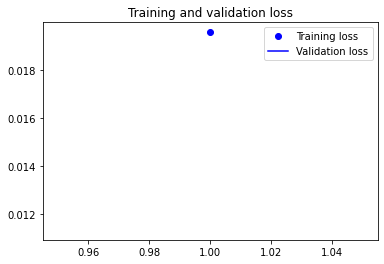

In [ ]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
# epochs = range(200)
plt.figure()
plt.plot(1, loss, 'bo', label='Training loss')
plt.plot(1, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
autoencoder.save_weights('/content/drive/MyDrive/7th- Semester/FashionMNIST/FASHIONMNISTautoencoder.h5')
# '/content/drive/MyDrive/7th- Semester/FashionMNIST/t10k-labels-idx1-ubyte.gz',10000)

In [ ]:
import keras.utils
from keras import utils as np_utils

In [ ]:
# Segmenting the fashion mnist images
# Now you will be using the trained autoencoder's head, i.e., the encoder part and will be loading the weights of the autoencoder you just now trained but only in the encoder part of the model.
# You will add a few dense or fully connected layers to the encoder to classify fashion mnist images.
#     Let's first convert the labels into one-hot encoding vectors.
#     For those of you who do not know about one-hot encoding:
#     In one-hot encoding, you convert the categorical data into a vector of numbers. 
# The reason why you convert the categorical data in one hot encoding is that machine learning algorithms cannot work with categorical data directly.
#  You generate one boolean column for each category or class. Only one of these columns could take on the value 1 for each sample. Hence, the term one-hot encoding.
#     For your problem statement, the one hot encoding will be a row vector, and for each image,
#  it will have a dimension of 1 x 10. The important thing to note here is that the vector consists of all zeros except for the class that it represents, and for that, it is 1.
#     So let's convert the labels into one-hot encoding vectors:
from tensorflow.keras.utils import to_categorical # Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_labels) 
test_Y_one_hot = to_categorical(test_labels)
# Display the change for category label using one-hot encoding
print('Original label:', train_labels[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

# That's pretty clear, right?
    # This last step is a crucial one which you all have done before as well which is splitting the data into training and validation in the autoencoder training phase. So let's quickly do that step for classification as well. Note that you will use the same random state that you used before and also this time you will pass your labels as well that you just now converted into a one-hot encoding vector.

    
    

Original label: 9
After conversion to one-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [ ]:
train_X,valid_X,train_label,valid_label = train_test_split(train_data,train_Y_one_hot,test_size=0.2,random_state=13)
# For one last time let's check the shape of training and validation set.
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape


((48000, 28, 28, 1), (12000, 28, 28, 1), (48000, 10), (12000, 10))

In [ ]:
# autoencoder.save_weights('autoencoder.h5')

def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4



In [ ]:
input_img[0][0]

<KerasTensor: shape=(28, 1) dtype=float32 (created by layer 'tf.__operators__.getitem_1')>

In [ ]:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(den)
    return out

encode = encoder(input_img)
full_model = Model(input_img,fc(encode))

for l1,l2 in zip(full_model.layers[:19],autoencoder.layers[0:19]):
    l1.set_weights(l2.get_weights())

In [ ]:
autoencoder.get_weights()[0][1]

array([[[-0.10972736,  0.1412479 ,  0.04480466, -0.1497556 ,
         -0.09553414,  0.12620619,  0.14871094,  0.02645838,
          0.00315898,  0.03999595,  0.12085675, -0.07324249,
         -0.05615313,  0.03119145,  0.00192349,  0.06490435,
         -0.03936107, -0.06159118, -0.00608666,  0.09949011,
         -0.04740502, -0.14852351,  0.10553352,  0.07978274,
          0.14853783, -0.08903937,  0.10618052,  0.00050346,
          0.05130543,  0.14782082,  0.15119953, -0.10190051]],

       [[-0.11406079, -0.11755417,  0.12420368,  0.06677188,
          0.10806774,  0.12401075,  0.00315239, -0.11059904,
         -0.143833  , -0.03489171,  0.12246311,  0.07534908,
         -0.03430961, -0.06675816,  0.04640457, -0.10350453,
         -0.114095  , -0.07009452,  0.02028428,  0.02610117,
         -0.09709974, -0.13219036, -0.10051478, -0.0036644 ,
         -0.00646222,  0.12139625,  0.14589262, -0.07067588,
         -0.14373446,  0.07853204,  0.09411597,  0.11094949]],

       [[ 0.098973

In [ ]:
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))

In [ ]:
for l1,l2 in zip(full_model.layers[:19],autoencoder.layers[0:19]):
    l1.set_weights(l2.get_weights())

In [ ]:
full_model.get_weights()[0][1]

array([[[-0.10972736,  0.1412479 ,  0.04480466, -0.1497556 ,
         -0.09553414,  0.12620619,  0.14871094,  0.02645838,
          0.00315898,  0.03999595,  0.12085675, -0.07324249,
         -0.05615313,  0.03119145,  0.00192349,  0.06490435,
         -0.03936107, -0.06159118, -0.00608666,  0.09949011,
         -0.04740502, -0.14852351,  0.10553352,  0.07978274,
          0.14853783, -0.08903937,  0.10618052,  0.00050346,
          0.05130543,  0.14782082,  0.15119953, -0.10190051]],

       [[-0.11406079, -0.11755417,  0.12420368,  0.06677188,
          0.10806774,  0.12401075,  0.00315239, -0.11059904,
         -0.143833  , -0.03489171,  0.12246311,  0.07534908,
         -0.03430961, -0.06675816,  0.04640457, -0.10350453,
         -0.114095  , -0.07009452,  0.02028428,  0.02610117,
         -0.09709974, -0.13219036, -0.10051478, -0.0036644 ,
         -0.00646222,  0.12139625,  0.14589262, -0.07067588,
         -0.14373446,  0.07853204,  0.09411597,  0.11094949]],

       [[ 0.098973

In [ ]:
# Voila! Both the arrays look exactly similar. So, without any further ado, let's compile the model and start the training.

# Next, you will make the encoder part i.e.the first nineteen layers of the model trainable false. 
# Since the encoder part is already trained, you do not need to train it. You will only be training the Fully Connected part.

for layer in full_model.layers[0:19]:
    layer.trainable = False


In [ ]:
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=Adam(),metrics=['accuracy'])
# train_X,valid_X,train_ground,valid_ground 
# classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=100,verbose=1,validation_data=(valid_X, valid_label))

In [ ]:
# classify_train = full_model.fit(train_X, train_ground, batch_size=64,epochs=100,verbose=1,validation_data=(valid_X, valid_ground))
classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=1,verbose=1,validation_data=(valid_X, valid_label))

750/750 [==============================] - 163s 216ms/step - loss: 0.5300 - accuracy: 0.8377 - val_loss: 0.3886 - val_accuracy: 0.8642


In [ ]:
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (48000, 10), (12000, 10))

In [ ]:
full_model.save_weights('/content/drive/MyDrive/7th- Semester/FashionMNIST/FASHIONMNIST_classification_complete.h5')

In [ ]:
accuracy = classify_train.history['acc']
val_accuracy = classify_train.history['val_acc']
loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
test_eval = full_model.evaluate(test_data, test_Y_one_hot, verbose=0)

In [ ]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.41077715158462524
Test accuracy: 0.8565000295639038


In [ ]:
predicted_classes = full_model.predict(test_data)

In [ ]:
predicted_classes

array([[9.68984892e-09, 7.44540596e-10, 2.97807307e-10, ...,
        3.72564798e-04, 7.17233206e-09, 9.99621987e-01],
       [5.20240108e-04, 1.98145244e-07, 9.98265445e-01, ...,
        6.05053854e-12, 4.84370548e-06, 4.22508339e-09],
       [4.69442790e-13, 1.00000000e+00, 2.12531697e-16, ...,
        6.30839510e-14, 9.78159238e-15, 2.14527725e-20],
       ...,
       [6.74457333e-05, 2.13229691e-06, 4.27077175e-05, ...,
        1.09895346e-07, 9.98318791e-01, 3.14691260e-06],
       [2.54944954e-10, 9.99998093e-01, 1.36849669e-08, ...,
        1.33550476e-10, 1.34166669e-08, 1.59423880e-11],
       [4.90065077e-06, 4.80041024e-07, 3.48181420e-05, ...,
        2.93680787e-01, 1.17595878e-03, 4.74074564e-04]], dtype=float32)

In [ ]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

In [ ]:
predicted_classes

array([9, 2, 1, ..., 8, 1, 5])

In [ ]:
predicted_classes.shape, test_labels.shape

((10000,), (10000,))

Found 8444 correct labels


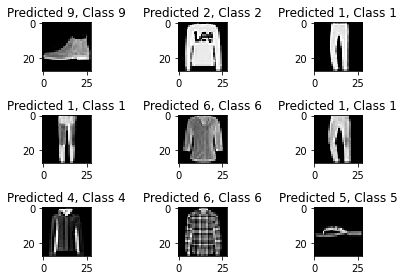

In [ ]:
correct = np.where(predicted_classes==test_labels)[0]
print ("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_data[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], test_labels[correct]))
    plt.tight_layout()


In [ ]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(test_labels, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.58      0.89      0.70      1000
     Class 1       0.98      0.96      0.97      1000
     Class 2       0.85      0.61      0.71      1000
     Class 3       0.88      0.88      0.88      1000
     Class 4       0.76      0.79      0.78      1000
     Class 5       0.94      0.97      0.95      1000
     Class 6       0.72      0.56      0.63      1000
     Class 7       0.95      0.89      0.92      1000
     Class 8       0.98      0.95      0.96      1000
     Class 9       0.93      0.94      0.94      1000

    accuracy                           0.84     10000
   macro avg       0.86      0.84      0.84     10000
weighted avg       0.86      0.84      0.84     10000

